# Классификация изображений планктона

В данной работе рассматривается задача классификации изображений планктона.

Цель работы - построить устойчивый пайплайн классификации изображений и провести сравнительный анализ различных стратегий обучения нейронных сетей, включая обучение с нуля и transfer learning.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
from collections import Counter
from PIL import Image
from pathlib import Path
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Анализ датасета

Классы: ['Leegaardiella_ovalis', 'Mesodinium_sp', 'amoeba']
Кол-во: {0: 10, 1: 676, 2: 14}
Всего: 700


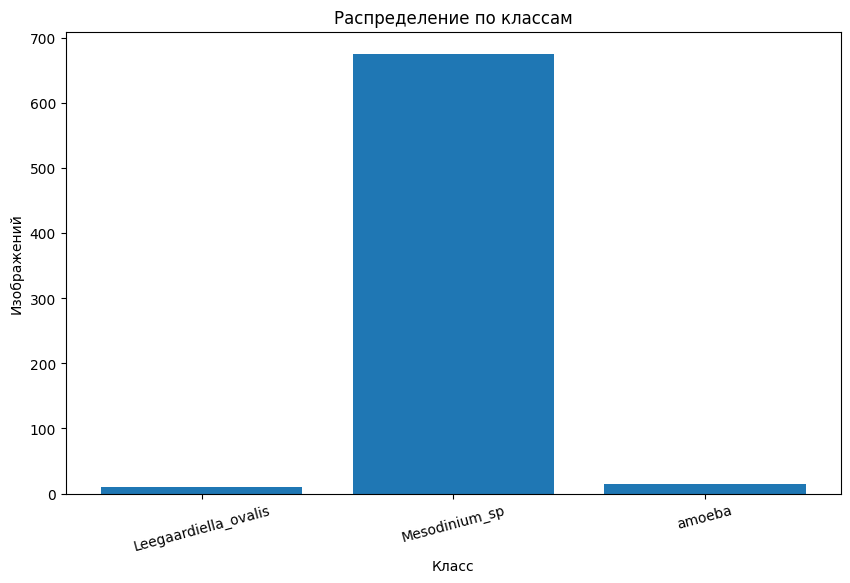

In [ ]:
base_dir = Path('/data')
img_dim = 224

# Получение списка классов
class_names = sorted([d.name for d in base_dir.iterdir() if d.is_dir()])
idx_map = {c: i for i, c in enumerate(class_names)}

# Создаем список всех изображений с их метками
files = []
for cls in class_names:
    cls_dir = base_dir / cls
    for img in cls_dir.glob("*.png"):
        files.append((img, idx_map[cls]))

# Подсчет количества изображений в каждом классе
stats = Counter(l for _, l in files)

print(f"Классы: {class_names}")
print(f"Кол-во: {dict(stats)}")
print(f"Всего: {len(files)}")

# Визуализация распределения классов
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(class_names, [stats[i] for i in range(len(class_names))])
ax.set_title("Распределение по классам")
ax.set_xlabel("Класс")
ax.set_ylabel("Изображений")
plt.xticks(rotation=15)
plt.show()

Датасет характеризуется выраженным дисбалансом:
Класс Mesodinium_sp содержит на порядок больше изображений, чем два других. В таких условиях использование accuracy в качестве основной метрики может быть вводящим в заблуждение, поэтому в дальнейшем основное внимание уделяется macro F1-score.

## Предобработка изображений

Для обеспечения стабильного обучения нейронной сети все изображения приводятся к единому формату:

* Изменение размера до 224×224 пикселей

* Нормализация по статистике ImageNet

Аугментации данных (только для обучающей выборки):

* Повороты и отражения (планктон свободно плавает в пространстве)

* Небольшие аффинные преобразования (имитация движения в воде)

* Легкая коррекция цвета (вариации освещения микроскопа)

* Минимальное размытие (изменения фокусировки)

Недопустимые аугментации:

* RandomPerspective - не соответствует оптике микроскопа

* ElasticTransform/GridDistortion - искажает морфологию организмов

* Агрессивный RandomCrop - отсекает структурные элементы

* Mixup/CutMix - биологически некорректное смешивание

* Сильное изменение цвета - цвет является важным признаком

* Резкая бинаризация - теряет градиенты интенсивности

* Черно-белые преобразования - уничтожают цветовые признаки

Обоснование: Микроскопические изображения планктона должны сохранять морфологическую целостность и цветовые характеристики, так как они являются ключевыми для идентификации.

In [ ]:
ImageNet_mean = [0.485, 0.456, 0.406]
ImageNet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((img_dim, img_dim)),
    
    # Ориентация:
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    
    # Реалистичные искажения:
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=(-2, 2, -2, 2)),
    
    # Изменения цвета:
    transforms.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.05),
    
    # Дополнительные аугментации:
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.3))], p=0.2),
    
    transforms.ToTensor(),
    transforms.Normalize(ImageNet_mean, ImageNet_std),
])

val_transform = transforms.Compose([
    transforms.Resize((img_dim, img_dim)),
    transforms.ToTensor(),
    transforms.Normalize(ImageNet_mean, ImageNet_std),
])

### Dataset, балансировка классов и кросс-валидация:

Для компенсации дисбаланса используется взвешенное семплирование, позволяющее формировать батчи с равномерным представлением классов. Каждое изображение получает вес, обратно пропорциональный размеру его класса, что увеличивает вероятность выбора примеров из миноритарных классов.

Для надежной оценки на малом датасете применяется стратифицированная кросс-валидация, которая сохраняет пропорции классов в каждом фолде и исключает утечку данных между обучающей и валидационной выборками.
Аугментации применяются только к обучающей выборке, валидационные данные преобразуются только для изменения размера и нормализации.

In [5]:
class PlanktonDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


def create_cv_dataloaders(samples, class_names, batch_size=8, n_splits=5, fold=0, random_state=42):
    # Подготавливаем данные для StratifiedKFold
    paths = np.array([str(p) for p, _ in samples])
    labels = np.array([l for _, l in samples])
    
    # Создаем KFold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Получаем индексы для текущего фолда
    all_indices = list(skf.split(paths, labels))
    train_idx, val_idx = all_indices[fold]
    
    train_samples = [(Path(p), l) for p, l in zip(paths[train_idx], labels[train_idx])]
    val_samples = [(Path(p), l) for p, l in zip(paths[val_idx], labels[val_idx])]
    
    # Создаем Dataset
    train_ds = PlanktonDataset(train_samples, train_transform)
    val_ds = PlanktonDataset(val_samples, val_transform)
    
    # Балансировка для тренировочной выборки
    train_labels_fold = [label for _, label in train_samples]
    class_counts = Counter(train_labels_fold)
    weights = [1.0 / class_counts[label] for label in train_labels_fold]
    
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
    
    # Создаем DataLoader
    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, train_samples, val_samples

### Архитектуры моделей

В работе сравниваются три подхода:

1. **Собственная CNN**

2. **Предобученная ConvNeXt-Tiny**  
   Тестируются три стратегии fine-tuning:
   - `classifier_only` - обучение только финального классификационного слоя
   - `partial` - разморозка последнего residual-блока
   - `full` - полное дообучение всей сети

3. **Предобученная EfficientNet-B4**  
   Тестируется с теми же стратегиями fine-tuning.

In [ ]:
# Собственная CNN
class PlanktonNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(

            nn.Conv2d(3, 32, 7, 2, 3, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1),
            
            nn.Conv2d(32, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

In [7]:
# Предобученная ConvNeXt-Tiny
def build_convnext_tiny(strategy, num_classes):
    model = models.convnext_tiny(
        weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1
    )
    
    if strategy == "classifier_only":
        for param in model.features.parameters():
            param.requires_grad = False
            
    elif strategy == "partial":
        for param in model.parameters():
            param.requires_grad = False

        for param in model.features[-2:].parameters():
            param.requires_grad = True
        
        for param in model.classifier.parameters():
            param.requires_grad = True
            
    elif strategy == "full":
        pass

    in_features = model.classifier[2].in_features
    model.classifier = nn.Sequential(
        model.classifier[0],
        model.classifier[1],
        nn.Linear(in_features, num_classes)
    )
    
    return model

In [8]:
# Предобученная EfficientNet-B4
def build_efficientnet_b4(strategy, num_classes):
    model = models.efficientnet_b4(
        weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1
    )
    
    if strategy == "classifier_only":
        for param in model.features.parameters():
            param.requires_grad = False
            
    elif strategy == "partial":
        for param in model.features.parameters():
            param.requires_grad = False
        for param in model.features[5:].parameters():
            param.requires_grad = True
            
    elif strategy == "full":
        pass
    
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.4, inplace=True),
        nn.Linear(in_features, num_classes)
    )
    
    return model

### Процесс обучения модели

Обучение проводится со следующими настройками:

* Optimizer: Adam с фильтрацией по requires_grad для поддержки стратегий fine-tuning

* Loss function: CrossEntropyLoss с весами классов для компенсации дисбаланса

* Ранняя остановка: по validation loss с patience = 5 эпох

* Максимальное число эпох: 40

Для оценки используется accuracy и macro F1-score, причем последний является основной метрикой благодаря устойчивости к дисбалансу классов. Дополнительно применяются взвешенные веса в функции потерь, пропорциональные обратному размеру классов.

In [9]:
def train_model(
    model,
    train_loader,
    val_loader,
    batch_size,
    epochs=40,
    lr=1e-3,
    patience=5,
    model_name="Model",
    strategy="from_scratch",
    total_experiments=1,
    experiment_idx=1
):
    model = model.to(device)
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=lr
    )

    class_counts = Counter([label for _, label in train_loader.dataset.samples])
    class_weights = torch.tensor([
        1.0 / class_counts[i] for i in range(len(class_counts))
    ]).to(device)
    class_weights = class_weights / class_weights.sum() * len(class_counts)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    best_loss = float("inf")
    patience_ctr = 0
    best_state = None
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    desc_text = (
        f"[{experiment_idx}/{total_experiments}] "
        f"{model_name}-{strategy} bs={batch_size}"
    )

    epoch_bar = tqdm(
        range(epochs),
        desc=desc_text,
        ascii=True,
        leave=True,
        dynamic_ncols=False
    )

    for epoch in epoch_bar:
        model.train()
        train_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(imgs), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Валидация
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                val_loss += criterion(outputs, labels).item()
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct / total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        epoch_bar.set_postfix({
            "train_loss": f"{train_loss:.4f}",
            "val_loss": f"{val_loss:.4f}",
            "val_acc": f"{val_acc:.3f}"
        })

        # Ранняя остановка
        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()
            patience_ctr = 0
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                epoch_bar.write(f"Ранняя остановка на эпохе: {epoch+1}")
                break

    model.load_state_dict(best_state)
    return model, history

### Оценка качества модели

Для объективной оценки в условиях дисбаланса классов используется расширенный набор метрик:

* **Accuracy** - общая точность классификации
* **Balanced Accuracy** - точность, усредненная по классам
* **Macro F1-score** - основная метрика сравнения, усредняет F1 по всем классам без учета их размера
* **Cohen's Kappa** - учитывает вероятность случайного угадывания
* **Matthews Correlation Coefficient** - корреляция между предсказаниями и истинными метками
* **Weighted F1-score** - учитывает размер классов, показывает общую эффективность
* **Per-class F1-score** - позволяет выявить проблемные классы

Macro F1-score является основной метрикой для сравнения моделей, так как наиболее устойчива к дисбалансу классов в датасете и обеспечивает равное внимание к миноритарным классам.

In [10]:
def evaluate_model(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            outputs = model(imgs.to(device))
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    report = classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        output_dict=True
    )
    
    kappa = cohen_kappa_score(all_labels, all_preds)
    mcc = matthews_corrcoef(all_labels, all_preds)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    return {
        "accuracy": report["accuracy"],
        "balanced_accuracy": balanced_acc,
        "macro_f1": report["macro avg"]["f1-score"],
        "weighted_f1": report["weighted avg"]["f1-score"],
        "cohens_kappa": kappa,
        "matthews_corrcoef": mcc,
        "per_class_f1": {cls: report[cls]["f1-score"] for cls in class_names}
    }

### Экспериментальная часть

Проводится серия экспериментов с кросс-валидацией для сравнения различных подходов.

**Тестируемые архитектуры:**

* PlanktonNet

* ConvNeXt-Tiny

* EfficientNet-B4

**Параметры экспериментов:**

* Кросс-валидация: 3 фолда (стратифицированная)

* Размеры батча: 8 и 16 изображений

**Стратегии fine-tuning:**

* classifier_only - обучение только классификатора

* partial - частичное дообучение последних слоев

* full - полное дообучение

Каждая модель оценивается по полному набору метрик с акцентом на Macro F1-score для корректного сравнения при дисбалансе классов.

In [12]:
def run_comprehensive_cv_experiments(files, class_names, batch_sizes=[8, 16], n_splits=3):
    results = []
    
    strategies = ["classifier_only", "partial", "full"]
    
    # Рассчитываем общее количество экспериментов
    total_experiments = len(batch_sizes) * n_splits * (1 + len(strategies) * 2)
    experiment_count = 0
    
    for bs in batch_sizes:
        print(f"Размер батча: {bs}")
        
        for fold in range(n_splits):
            print(f"\nФолд {fold+1}/{n_splits} (batch_size={bs})")
            
            train_loader, val_loader, _, _ = create_cv_dataloaders(
                files, class_names, batch_size=bs, n_splits=n_splits, fold=fold
            )
            
            experiment_count += 1
            print(f"\nЭксперимент {experiment_count}/{total_experiments}")
            print(f"Модель: PlanktonNet (from_scratch)")
            
            model = PlanktonNet(num_classes=len(class_names))
            model, history = train_model(
                model, train_loader, val_loader, 
                batch_size=bs,
                total_experiments=total_experiments,
                experiment_idx=experiment_count,
                lr=1e-3, model_name="PlanktonNet", strategy="from_scratch"
            )
            metrics = evaluate_model(model, val_loader)
            results.append({
                "model": "PlanktonNet",
                "strategy": "from_scratch",
                "batch_size": bs,
                "fold": fold + 1,
                **metrics
            })
            
            for strategy in strategies:
                experiment_count += 1
                print(f"\nЭксперимент {experiment_count}/{total_experiments}")
                print(f"Модель: ConvNeXt-Tiny ({strategy})")
                
                model = build_convnext_tiny(strategy, num_classes=len(class_names))
                lr = 5e-5 if strategy != "classifier_only" else 1e-3
                model, history = train_model(
                    model, train_loader, val_loader,
                    batch_size=bs,
                    total_experiments=total_experiments,
                    experiment_idx=experiment_count,
                    lr=lr, model_name="ConvNeXt-Tiny", strategy=strategy
                )
                metrics = evaluate_model(model, val_loader)
                results.append({
                    "model": "ConvNeXt-Tiny",
                    "strategy": strategy,
                    "batch_size": bs,
                    "fold": fold + 1,
                    "learning_rate": lr,
                    **metrics
                })
                
            for strategy in strategies:
                experiment_count += 1
                print(f"\nЭксперимент {experiment_count}/{total_experiments}")
                print(f"Модель: EfficientNet-B4 ({strategy})")
                
                model = build_efficientnet_b4(strategy, num_classes=len(class_names))
                lr = 5e-5 if strategy != "classifier_only" else 1e-3
                model, history = train_model(
                    model, train_loader, val_loader,
                    batch_size=bs,
                    total_experiments=total_experiments,
                    experiment_idx=experiment_count,
                    lr=lr, model_name="EfficientNet-B4", strategy=strategy
                )
                metrics = evaluate_model(model, val_loader)
                results.append({
                    "model": "EfficientNet-B4",
                    "strategy": strategy,
                    "batch_size": bs,
                    "fold": fold + 1,
                    "learning_rate": lr,
                    **metrics
                })
            
            print(f"\nЗавершен фолд {fold+1}/{n_splits}")
    
    return pd.DataFrame(results)

In [13]:
full_results_df = run_comprehensive_cv_experiments(files, class_names, batch_sizes=[8, 16], n_splits=3)

Размер батча: 8

Фолд 1/3 (batch_size=8)

Эксперимент 1/42
Модель: PlanktonNet (from_scratch)


[1/42] PlanktonNet-from_scratch bs=8:  12%|#2        | 5/40 [00:37<04:23,  7.53s/it, train_loss=0.2548, val_loss=3.9154, val_acc=0.030] 


Ранняя остановка на эпохе: 6

Эксперимент 2/42
Модель: ConvNeXt-Tiny (classifier_only)


[2/42] ConvNeXt-Tiny-classifier_only bs=8:  68%|######7   | 27/40 [03:01<01:27,  6.72s/it, train_loss=0.0012, val_loss=0.0806, val_acc=0.970]


Ранняя остановка на эпохе: 28

Эксперимент 3/42
Модель: ConvNeXt-Tiny (partial)


[3/42] ConvNeXt-Tiny-partial bs=8:  45%|####5     | 18/40 [02:02<02:29,  6.79s/it, train_loss=0.0004, val_loss=0.0211, val_acc=0.996]


Ранняя остановка на эпохе: 19

Эксперимент 4/42
Модель: ConvNeXt-Tiny (full)


[4/42] ConvNeXt-Tiny-full bs=8:  25%|##5       | 10/40 [01:28<04:26,  8.88s/it, train_loss=0.0022, val_loss=0.0370, val_acc=0.996]


Ранняя остановка на эпохе: 11

Эксперимент 5/42
Модель: EfficientNet-B4 (classifier_only)


[5/42] EfficientNet-B4-classifier_only bs=8:  15%|#5        | 6/40 [00:45<04:18,  7.62s/it, train_loss=0.1661, val_loss=2.1434, val_acc=0.038]


Ранняя остановка на эпохе: 7

Эксперимент 6/42
Модель: EfficientNet-B4 (partial)


[6/42] EfficientNet-B4-partial bs=8:  12%|#2        | 5/40 [00:46<05:27,  9.36s/it, train_loss=0.1051, val_loss=2.8489, val_acc=0.038]


Ранняя остановка на эпохе: 6

Эксперимент 7/42
Модель: EfficientNet-B4 (full)


[7/42] EfficientNet-B4-full bs=8:  12%|#2        | 5/40 [00:53<06:11, 10.62s/it, train_loss=0.1074, val_loss=2.7467, val_acc=0.038]


Ранняя остановка на эпохе: 6

Завершен фолд 1/3

Фолд 2/3 (batch_size=8)

Эксперимент 8/42
Модель: PlanktonNet (from_scratch)


[8/42] PlanktonNet-from_scratch bs=8:  30%|###       | 12/40 [01:19<03:04,  6.60s/it, train_loss=0.1484, val_loss=5.8596, val_acc=0.026]


Ранняя остановка на эпохе: 13

Эксперимент 9/42
Модель: ConvNeXt-Tiny (classifier_only)


[9/42] ConvNeXt-Tiny-classifier_only bs=8:  30%|###       | 12/40 [01:24<03:16,  7.00s/it, train_loss=0.0088, val_loss=0.5081, val_acc=0.785]


Ранняя остановка на эпохе: 13

Эксперимент 10/42
Модель: ConvNeXt-Tiny (partial)


[10/42] ConvNeXt-Tiny-partial bs=8:  40%|####      | 16/40 [01:49<02:44,  6.84s/it, train_loss=0.0015, val_loss=0.0064, val_acc=1.000]


Ранняя остановка на эпохе: 17

Эксперимент 11/42
Модель: ConvNeXt-Tiny (full)


[11/42] ConvNeXt-Tiny-full bs=8:  62%|######2   | 25/40 [03:27<02:04,  8.32s/it, train_loss=0.0002, val_loss=0.0006, val_acc=1.000]


Ранняя остановка на эпохе: 26

Эксперимент 12/42
Модель: EfficientNet-B4 (classifier_only)


[12/42] EfficientNet-B4-classifier_only bs=8:  12%|#2        | 5/40 [00:38<04:30,  7.73s/it, train_loss=0.2434, val_loss=1.8422, val_acc=0.047]


Ранняя остановка на эпохе: 6

Эксперимент 13/42
Модель: EfficientNet-B4 (partial)


[13/42] EfficientNet-B4-partial bs=8:  12%|#2        | 5/40 [00:46<05:28,  9.38s/it, train_loss=0.1408, val_loss=3.2750, val_acc=0.030]


Ранняя остановка на эпохе: 6

Эксперимент 14/42
Модель: EfficientNet-B4 (full)


[14/42] EfficientNet-B4-full bs=8:  12%|#2        | 5/40 [00:51<05:58, 10.25s/it, train_loss=0.1183, val_loss=3.4257, val_acc=0.030]


Ранняя остановка на эпохе: 6

Завершен фолд 2/3

Фолд 3/3 (batch_size=8)

Эксперимент 15/42
Модель: PlanktonNet (from_scratch)


[15/42] PlanktonNet-from_scratch bs=8:  25%|##5       | 10/40 [01:07<03:21,  6.73s/it, train_loss=0.3283, val_loss=5.0003, val_acc=0.021]


Ранняя остановка на эпохе: 11

Эксперимент 16/42
Модель: ConvNeXt-Tiny (classifier_only)


[16/42] ConvNeXt-Tiny-classifier_only bs=8:  95%|#########5| 38/40 [04:11<00:13,  6.62s/it, train_loss=0.0022, val_loss=0.0691, val_acc=0.970]


Ранняя остановка на эпохе: 39

Эксперимент 17/42
Модель: ConvNeXt-Tiny (partial)


[17/42] ConvNeXt-Tiny-partial bs=8:  60%|######    | 24/40 [02:38<01:45,  6.60s/it, train_loss=0.0003, val_loss=0.0071, val_acc=0.991]


Ранняя остановка на эпохе: 25

Эксперимент 18/42
Модель: ConvNeXt-Tiny (full)


[18/42] ConvNeXt-Tiny-full bs=8:  35%|###5      | 14/40 [01:58<03:40,  8.49s/it, train_loss=0.0003, val_loss=0.0060, val_acc=0.991]


Ранняя остановка на эпохе: 15

Эксперимент 19/42
Модель: EfficientNet-B4 (classifier_only)


[19/42] EfficientNet-B4-classifier_only bs=8:  12%|#2        | 5/40 [00:39<04:35,  7.87s/it, train_loss=0.2205, val_loss=2.0809, val_acc=0.043]


Ранняя остановка на эпохе: 6

Эксперимент 20/42
Модель: EfficientNet-B4 (partial)


[20/42] EfficientNet-B4-partial bs=8:  12%|#2        | 5/40 [00:45<05:21,  9.18s/it, train_loss=0.1378, val_loss=3.4301, val_acc=0.034]


Ранняя остановка на эпохе: 6

Эксперимент 21/42
Модель: EfficientNet-B4 (full)


[21/42] EfficientNet-B4-full bs=8:  12%|#2        | 5/40 [00:51<06:03, 10.37s/it, train_loss=0.1374, val_loss=3.1679, val_acc=0.034]


Ранняя остановка на эпохе: 6

Завершен фолд 3/3
Размер батча: 16

Фолд 1/3 (batch_size=16)

Эксперимент 22/42
Модель: PlanktonNet (from_scratch)


[22/42] PlanktonNet-from_scratch bs=16:  38%|###7      | 15/40 [01:32<02:34,  6.19s/it, train_loss=0.1713, val_loss=8.2139, val_acc=0.021]


Ранняя остановка на эпохе: 16

Эксперимент 23/42
Модель: ConvNeXt-Tiny (classifier_only)


[23/42] ConvNeXt-Tiny-classifier_only bs=16:  75%|#######5  | 30/40 [03:08<01:02,  6.30s/it, train_loss=0.0020, val_loss=0.1079, val_acc=0.970]


Ранняя остановка на эпохе: 31

Эксперимент 24/42
Модель: ConvNeXt-Tiny (partial)


[24/42] ConvNeXt-Tiny-partial bs=16:  62%|######2   | 25/40 [02:34<01:32,  6.18s/it, train_loss=0.0005, val_loss=0.0194, val_acc=0.996]


Ранняя остановка на эпохе: 26

Эксперимент 25/42
Модель: ConvNeXt-Tiny (full)


[25/42] ConvNeXt-Tiny-full bs=16:  42%|####2     | 17/40 [03:37<04:53, 12.78s/it, train_loss=0.0003, val_loss=0.0344, val_acc=0.996]


Ранняя остановка на эпохе: 18

Эксперимент 26/42
Модель: EfficientNet-B4 (classifier_only)


[26/42] EfficientNet-B4-classifier_only bs=16:  12%|#2        | 5/40 [00:36<04:14,  7.27s/it, train_loss=0.2238, val_loss=2.1458, val_acc=0.051]


Ранняя остановка на эпохе: 6

Эксперимент 27/42
Модель: EfficientNet-B4 (partial)


[27/42] EfficientNet-B4-partial bs=16:  12%|#2        | 5/40 [00:38<04:27,  7.66s/it, train_loss=0.2238, val_loss=2.5379, val_acc=0.038]


Ранняя остановка на эпохе: 6

Эксперимент 28/42
Модель: EfficientNet-B4 (full)


[28/42] EfficientNet-B4-full bs=16:  12%|#2        | 5/40 [00:43<05:07,  8.79s/it, train_loss=0.2421, val_loss=2.6295, val_acc=0.038]


Ранняя остановка на эпохе: 6

Завершен фолд 1/3

Фолд 2/3 (batch_size=16)

Эксперимент 29/42
Модель: PlanktonNet (from_scratch)


[29/42] PlanktonNet-from_scratch bs=16:  32%|###2      | 13/40 [01:20<02:47,  6.20s/it, train_loss=0.1734, val_loss=2.6070, val_acc=0.030]


Ранняя остановка на эпохе: 14

Эксперимент 30/42
Модель: ConvNeXt-Tiny (classifier_only)


[30/42] ConvNeXt-Tiny-classifier_only bs=16:  78%|#######7  | 31/40 [03:15<00:56,  6.31s/it, train_loss=0.0024, val_loss=0.2394, val_acc=0.893]


Ранняя остановка на эпохе: 32

Эксперимент 31/42
Модель: ConvNeXt-Tiny (partial)


[31/42] ConvNeXt-Tiny-partial bs=16: 100%|##########| 40/40 [04:01<00:00,  6.03s/it, train_loss=0.0005, val_loss=0.0008, val_acc=1.000]



Эксперимент 32/42
Модель: ConvNeXt-Tiny (full)


[32/42] ConvNeXt-Tiny-full bs=16:  90%|######### | 36/40 [07:24<00:49, 12.36s/it, train_loss=0.0002, val_loss=0.0026, val_acc=1.000]


Ранняя остановка на эпохе: 37

Эксперимент 33/42
Модель: EfficientNet-B4 (classifier_only)


[33/42] EfficientNet-B4-classifier_only bs=16:  12%|#2        | 5/40 [00:36<04:12,  7.22s/it, train_loss=0.2618, val_loss=1.8152, val_acc=0.107]


Ранняя остановка на эпохе: 6

Эксперимент 34/42
Модель: EfficientNet-B4 (partial)


[34/42] EfficientNet-B4-partial bs=16:  12%|#2        | 5/40 [00:37<04:24,  7.55s/it, train_loss=0.2710, val_loss=3.0117, val_acc=0.030]


Ранняя остановка на эпохе: 6

Эксперимент 35/42
Модель: EfficientNet-B4 (full)


[35/42] EfficientNet-B4-full bs=16:  12%|#2        | 5/40 [00:45<05:16,  9.05s/it, train_loss=0.2938, val_loss=2.9585, val_acc=0.030]


Ранняя остановка на эпохе: 6

Завершен фолд 2/3

Фолд 3/3 (batch_size=16)

Эксперимент 36/42
Модель: PlanktonNet (from_scratch)


[36/42] PlanktonNet-from_scratch bs=16:  52%|#####2    | 21/40 [02:09<01:56,  6.15s/it, train_loss=0.2655, val_loss=5.3284, val_acc=0.026]


Ранняя остановка на эпохе: 22

Эксперимент 37/42
Модель: ConvNeXt-Tiny (classifier_only)


[37/42] ConvNeXt-Tiny-classifier_only bs=16: 100%|##########| 40/40 [04:02<00:00,  6.05s/it, train_loss=0.0018, val_loss=0.1425, val_acc=0.940]



Эксперимент 38/42
Модель: ConvNeXt-Tiny (partial)


[38/42] ConvNeXt-Tiny-partial bs=16:  68%|######7   | 27/40 [02:49<01:21,  6.27s/it, train_loss=0.0009, val_loss=0.0202, val_acc=0.991]


Ранняя остановка на эпохе: 28

Эксперимент 39/42
Модель: ConvNeXt-Tiny (full)


[39/42] ConvNeXt-Tiny-full bs=16:  55%|#####5    | 22/40 [04:37<03:47, 12.62s/it, train_loss=0.0003, val_loss=0.0031, val_acc=0.996]


Ранняя остановка на эпохе: 23

Эксперимент 40/42
Модель: EfficientNet-B4 (classifier_only)


[40/42] EfficientNet-B4-classifier_only bs=16:  15%|#5        | 6/40 [00:41<03:56,  6.95s/it, train_loss=0.2464, val_loss=1.9562, val_acc=0.056]


Ранняя остановка на эпохе: 7

Эксперимент 41/42
Модель: EfficientNet-B4 (partial)


[41/42] EfficientNet-B4-partial bs=16:  12%|#2        | 5/40 [00:40<04:41,  8.03s/it, train_loss=0.3095, val_loss=2.5882, val_acc=0.034]


Ранняя остановка на эпохе: 6

Эксперимент 42/42
Модель: EfficientNet-B4 (full)


[42/42] EfficientNet-B4-full bs=16:  12%|#2        | 5/40 [00:43<05:03,  8.68s/it, train_loss=0.2876, val_loss=2.4787, val_acc=0.034]


Ранняя остановка на эпохе: 6

Завершен фолд 3/3


In [ ]:
# Агрегация результатов экспериментов
summary = full_results_df.groupby(['model', 'strategy', 'batch_size']).agg({
    'accuracy': ['mean', 'std'],
    'balanced_accuracy': ['mean', 'std'],
    'macro_f1': ['mean', 'std'],
    'cohens_kappa': ['mean', 'std'],
    'matthews_corrcoef': ['mean', 'std']
}).round(4)

# Для удобства чтения переименуем колонки
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary = summary.reset_index()

print("Сводные результаты экспериментов:")
display(summary)

# Таблица лучших результатов по macro_f1_mean
best_results = summary.loc[summary.groupby(['model', 'batch_size'])['macro_f1_mean'].idxmax()]
print("\nЛучшие результаты по каждой модели (по Macro F1):")
display(best_results[['model', 'strategy', 'batch_size', 'macro_f1_mean', 'macro_f1_std']])

Сводные результаты экспериментов:


,model,strategy,batch_size,accuracy_mean,accuracy_std,balanced_accuracy_mean,balanced_accuracy_std,macro_f1_mean,macro_f1_std,cohens_kappa_mean,cohens_kappa_std,matthews_corrcoef_mean,matthews_corrcoef_std
0,ConvNeXt-Tiny,classifier_only,8,0.9085,0.1066,0.9139,0.0825,0.6933,0.1612,0.5092,0.2794,0.5711,0.2135
1,ConvNeXt-Tiny,classifier_only,16,0.9342,0.0390,0.9501,0.0375,0.6979,0.1074,0.5117,0.1749,0.5815,0.1267
2,ConvNeXt-Tiny,full,8,0.9957,0.0043,0.9985,0.0015,0.9614,0.0429,0.9438,0.0572,0.9463,0.0541
3,ConvNeXt-Tiny,full,16,0.9971,0.0025,0.9717,0.0477,0.9678,0.0279,0.9597,0.0349,0.9609,0.0339
4,ConvNeXt-Tiny,partial,8,0.9957,0.0043,0.9712,0.0473,0.9556,0.0425,0.9417,0.0572,0.9443,0.0542
5,ConvNeXt-Tiny,partial,16,0.9957,0.0043,0.9712,0.0473,0.9556,0.0425,0.9417,0.0572,0.9443,0.0542
6,EfficientNet-B4,classifier_only,8,0.0429,0.0044,0.6696,0.0029,0.0509,0.0021,0.0180,0.0015,0.0960,0.0030
7,EfficientNet-B4,classifier_only,16,0.0715,0.0311,0.6795,0.0120,0.0718,0.0215,0.0202,0.0011,0.1029,0.0053
8,EfficientNet-B4,full,8,0.0343,0.0042,0.6667,0.0000,0.0474,0.0101,0.0176,0.0026,0.0976,0.0124
9,EfficientNet-B4,full,16,0.0343,0.0042,0.6667,0.0000,0.0478,0.0014,0.0179,0.0017,0.0992,0.0012



Лучшие результаты по каждой модели (по Macro F1):


,model,strategy,batch_size,macro_f1_mean,macro_f1_std
2,ConvNeXt-Tiny,full,8,0.9614,0.0429
3,ConvNeXt-Tiny,full,16,0.9678,0.0279
6,EfficientNet-B4,classifier_only,8,0.0509,0.0021
7,EfficientNet-B4,classifier_only,16,0.0718,0.0215
12,PlanktonNet,from_scratch,8,0.0518,0.0043
13,PlanktonNet,from_scratch,16,0.0828,0.0380


## Финальный вывод
Эксперименты показали, что для классификации планктона на малом и несбалансированном датасете оптимальной является современная архитектура ConvNeXt-Tiny с полным дообучением, обеспечивающая 96.78% Macro F1-score при batch_size=16. Стратегия полного дообучения превзошла частичное дообучение и обучение только классификатора, что указывает на необходимость адаптации всей сети к специфике микроскопических изображений.

Ожидаемо, обучение с нуля (PlanktonNet) показало низкие результаты (5.18-8.28% Macro F1), подтверждая критическую важность transfer learning при ограниченном объеме данных. Неожиданным результатом стала крайне низкая эффективность EfficientNet-B4 (5.09-7.18% Macro F1), что может объясняться несовместимостью сложной архитектуры с малым датасетом или необходимостью специальной настройки гиперпараметров.

Влияние размера батча оказалось незначительным для качественных моделей, хотя batch_size=16 показал небольшое преимущество. Набор метрик, устойчивых к дисбалансу (Macro F1, Balanced Accuracy, Matthews Correlation Coefficient), подтвердил свою адекватность для объективной оценки моделей.

**Рекомендации для дальнейшего улучшения**
Для повышения качества классификации рекомендуется собрать дополнительный датасет, особенно для миноритарных классов Leegaardiella_ovalis и amoeba, что позволит преодолеть фундаментальное ограничение текущего исследования. Следует рассмотреть другие современные архитектуры (например, Vision Transformers или Swin Transformer) и экспериментировать с ансамблевыми методами для повышения устойчивости предсказаний. Также целесообразно проверить влияние различных размеров батча и других гиперпараметров, чтобы оптимизировать обучение на малых и несбалансированных датасетах.